In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [4]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [5]:
ds, ds_info = tfds.load('emnist/letters', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/88800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/3.0.0.incompleteB1OIK3/emnist-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/14800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/3.0.0.incompleteB1OIK3/emnist-test.tfrecord*...:   0%|     …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/letters/3.0.0. Subsequent calls will reuse this data.


In [6]:
train_ds, valid_ds = ds['train'], ds['test']

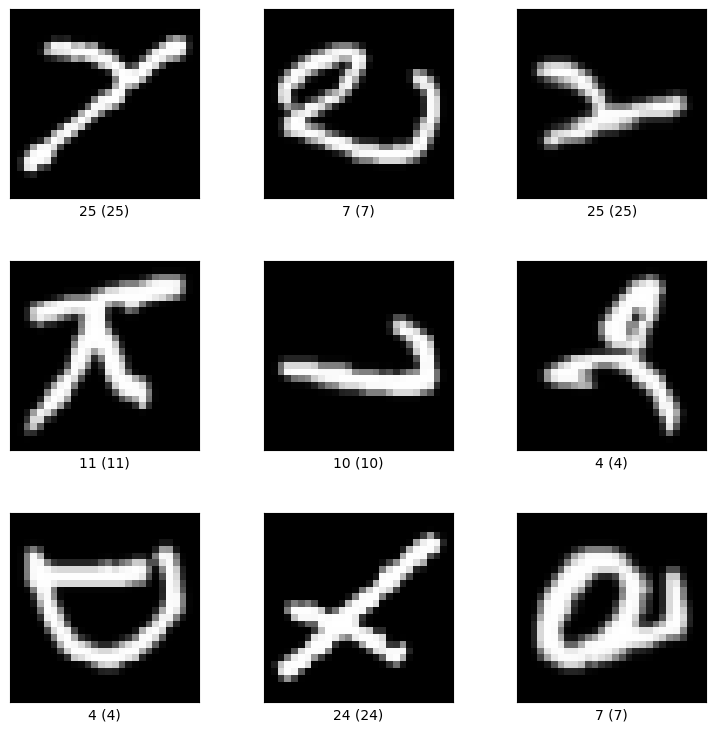

In [7]:
fig = tfds.show_examples(train_ds, ds_info)

In [8]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(ds_info.splits['train'].num_examples)
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)



valid_ds = valid_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.batch(128)
valid_ds = valid_ds.cache()
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
for image_batch, label_batch in train_ds.take(2):
  print(image_batch, 'image_batch')
  print(label_batch, 'label_batch')

tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=473, kernel_size= (3, 3), activation=tf.nn.relu, input_shape=(28,28,1)),
  tf.keras.layers.AveragePooling2D((2, 2)),
  tf.keras.layers.Dropout(rate=0.15),
  tf.keras.layers.Conv2D(filters=238, kernel_size= (3, 3), padding='valid', activation=tf.nn.leaky_relu),
  tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(rate=0.20),
  tf.keras.layers.Conv2D(filters=133, kernel_size= (3, 3), activation=tf.nn.relu),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(rate=0.10),
  tf.keras.layers.Conv2D(filters=387, kernel_size= (3, 3), activation=tf.nn.relu),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(rate=0.10),
  tf.keras.layers.Conv2D(filters=187, kernel_size= (5, 5), activation=tf.nn.elu),
  tf.keras.layers.Dropout(rate=0.50),
  #tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(313, activation=tf.nn.relu),
  tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(rate=0.20),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(252, activation=tf.nn.elu),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(rate=0.20),
  # tf.keras.layers.Flatten(),
  #tf.keras.layers.Dense(128,activation=tf.nn.relu),
  #tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(37, activation=tf.nn.softmax)
  #tf.keras.layers.Dense(37, activation=tf.nn.softmax)
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [12]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

In [14]:
epochs=50

history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1,
)

Epoch 1/50
694/694 [==============================] - 43s 62ms/step - loss: 0.2012 - accuracy: 0.9310 - val_loss: 0.2192 - val_accuracy: 0.9245
Epoch 2/50
694/694 [==============================] - 44s 63ms/step - loss: 0.1785 - accuracy: 0.9379 - val_loss: 0.2190 - val_accuracy: 0.9244
Epoch 3/50
694/694 [==============================] - 44s 63ms/step - loss: 0.1626 - accuracy: 0.9422 - val_loss: 0.2026 - val_accuracy: 0.9280
Epoch 4/50
694/694 [==============================] - 44s 63ms/step - loss: 0.1524 - accuracy: 0.9456 - val_loss: 0.1851 - val_accuracy: 0.9352
Epoch 5/50
694/694 [==============================] - 44s 63ms/step - loss: 0.1416 - accuracy: 0.9494 - val_loss: 0.2149 - val_accuracy: 0.9280
Epoch 6/50
694/694 [==============================] - 44s 63ms/step - loss: 0.1329 - accuracy: 0.9517 - val_loss: 0.1908 - val_accuracy: 0.9344
Epoch 7/50
694/694 [==============================] - 44s 63ms/step - loss: 0.1274 - accuracy: 0.9528 - val_loss: 0.1915 - val_accuracy:

In [16]:
model.save('model.h5')